In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

from pysr import PySRRegressor

from scipy.optimize import curve_fit

In [2]:
from physical_formula_spinvdisk2 import disks_physical_formula_func as phys_eqn

In [3]:
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy import constants as cons


def Delta(z,Om0=0.279,Ob0=0.046,h=0.7):
    #Bryan & Norman 99
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    x=cosmo.Om(z)-1
    return 18*np.pi**2+82*x-39*x**2

def rho_crit(z,Om0=0.279,Ob0=0.046,h=0.7):
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    return cosmo.critical_density(z).to(u.Msun/u.kpc**3).value

def rho_vir(z,Om0=0.279,Ob0=0.046,h=0.7):
    D=Delta(z,Om0=Om0,Ob0=Ob0,h=h)
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    rho_c = cosmo.critical_density(z).to(u.Msun/u.kpc**3).value
    return D*rho_c

def Rvir_to_Mvir(Rvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    rho_v = rho_vir(z,Om0=Om0,Ob0=Ob0,h=h)
    return rho_v*4./3.*np.pi*Rvir**3   #Msun

def Mvir_to_Rvir(Mvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    rho_v = rho_vir(z,Om0=Om0,Ob0=Ob0,h=h)
    return  (Mvir/(rho_v*4./3.*np.pi))**(1./3.)  #kpc

def Mvir_to_Vvir(Mvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    Rvir = Mvir_to_Rvir(Mvir,z,Om0=Om0,Ob0=Ob0,h=h)
    return (np.sqrt(cons.G*Mvir*u.Msun/(Rvir*u.kpc))).to(u.km/u.s)

## <font color='darkred'> TNG-SAM

In [4]:
# Normalized dataset: all masses divided by halo mass (Mvir)
df_normalized_31 = pd.read_csv('Halo Mass Normalized Dataset w 31 features.csv')

In [5]:
df_normalized_31.shape

(35390, 32)

In [6]:
# Remove non-physical galaxies whose Mstar/Mvir (GalpropNormMstar) > 0.2
df_normalized_31 = df_normalized_31[df_normalized_31.GalpropNormMstar < 0.2]

In [7]:
df_normalized_31.shape

(35368, 32)

In [8]:
# df here read from the data filtered file from notebook v5
df_log_mass_filtered_v5 = pd.read_csv ('df_log_mass_filtered_v5.csv') 

In [9]:
# Raw dataset
df_not_normalized = df_log_mass_filtered_v5.loc[: , :]

In [10]:
df_not_normalized.shape

(35390, 66)

#### Add Vvir to Raw Dataset

In [11]:
# Define Halo property Vvir (as it does not exist in the dataset above)
v= Mvir_to_Vvir (np.array(df_not_normalized.loc[:,'HalopropMvir']),0) # has units

In [12]:
v

<Quantity [21.18004688, 64.73085173, 62.76861958, ..., 47.8003278 ,
           48.5739648 , 48.11187183] km / s>

In [13]:
# add Halo property Vvir
df_not_normalized.loc[:, 'HalopropVvir']=v.value 

In [14]:
df_not_normalized.shape

(35390, 67)

#### Add Mstar/Vvir to Raw Dataset in order to remove non-physical galaxies with Mstar/Vvir > 0.2

In [15]:
df_not_normalized.loc[: , 'MstarMvir_ratio'] = df_not_normalized.loc[:, 'GalpropMstar']/df_not_normalized.loc[:, 'GalpropMvir']

df_not_normalized = df_not_normalized[df_not_normalized.MstarMvir_ratio < 0.2]

In [16]:
df_not_normalized.shape

(35368, 68)

In [17]:
df_not_normalized.shape

(35368, 68)

In [18]:
df_not_normalized.columns.to_list()

['GalpropMBH',
 'GalpropMH2',
 'GalpropMHI',
 'GalpropMHII',
 'GalpropMaccdot',
 'GalpropMaccdot_radio',
 'GalpropMbulge',
 'GalpropMcold',
 'GalpropMstar',
 'GalpropMstar_merge',
 'GalpropMstrip',
 'GalpropMu_merger',
 'GalpropMvir',
 'GalpropOutflowRate_Mass',
 'GalpropOutflowRate_Metal',
 'GalpropRbulge',
 'GalpropRdisk',
 'GalpropRedshift',
 'GalpropRfric',
 'GalpropRhalo',
 'GalpropSfr',
 'GalpropSfrave100myr',
 'GalpropSfrave1gyr',
 'GalpropSfrave20myr',
 'GalpropSigmaBulge',
 'GalpropTmerger',
 'GalpropTmerger_major',
 'GalpropTsat',
 'GalpropVdisk',
 'GalpropZcold',
 'GalpropZstar',
 'GalpropX',
 'GalpropVx',
 'GalpropY',
 'GalpropVy',
 'GalpropZ',
 'GalpropVz',
 'HalopropC_nfw',
 'HalopropMaccdot_metal',
 'HalopropMaccdot_pristine',
 'HalopropMaccdot_radio',
 'HalopropMaccdot_reaccreate',
 'HalopropMaccdot_reaccreate_metal',
 'HalopropMass_ejected',
 'HalopropMcooldot',
 'HalopropMdot_eject',
 'HalopropMdot_eject_metal',
 'HalopropMetal_ejected',
 'HalopropMhot',
 'HalopropMst

In [19]:
df_not_normalized.loc[:, 'GalpropMdisk'] = df_not_normalized.loc[:, 'GalpropMstar'] - df_not_normalized.loc[:, 'GalpropMbulge']

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [20]:
df_not_normalized.loc[:, 'BulgeMstar_ratio'] = df_not_normalized.loc[:,'GalpropMbulge']/df_not_normalized.loc[:, 'GalpropMstar']

In [21]:
df_not_normalized.loc[:, 'DiskMstar_ratio']  = df_not_normalized.loc[:, 'GalpropMdisk']/df_not_normalized.loc[:, 'GalpropMstar']

In [22]:
df_not_normalized.loc[:, 'WeightedRadius'] = df_not_normalized.loc[:, 'DiskMstar_ratio'] * df_not_normalized.loc[:, 'GalpropRdisk']

In [23]:
df_not_normalized.loc[:, 'WeightedRadius2'] = df_not_normalized.loc[:, 'BulgeMstar_ratio'] * \
            df_not_normalized.loc[:, 'GalpropRbulge'] + \
            df_not_normalized.loc[:, 'DiskMstar_ratio'] * df_not_normalized.loc[:, 'GalpropRdisk']

In [24]:
df_not_normalized.shape

(35368, 73)

### Weighted Radius vs Size

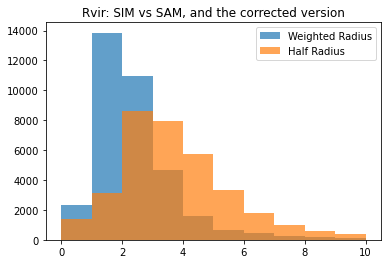

In [29]:
plt.hist(df_not_normalized.loc[:, 'WeightedRadius'], label='Weighted Radius', alpha=0.7, range=(0, 10))
plt.hist(df_not_normalized.loc[:, 'GalpropHalfRadius'], label='Half Radius', alpha=0.7, range=(0,10))
plt.title('Rvir: SIM vs SAM, and the corrected version')
plt.legend()
plt.show()

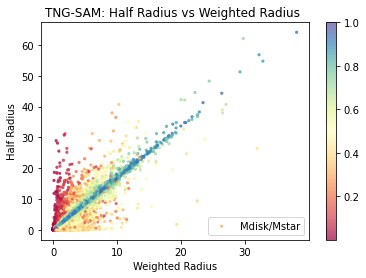

In [25]:
plt.scatter(df_not_normalized.loc[:, 'WeightedRadius'], df_not_normalized.loc[:, 'GalpropHalfRadius'], 
            c = df_not_normalized.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='Mdisk/Mstar') #, vmin=0.005, vmax=0.04)
plt.xlabel('Weighted Radius')
plt.ylabel('Half Radius')
plt.title('TNG-SAM: Half Radius vs Weighted Radius ')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('TNG_SAM_halfrad_weightedrad_MdiskMstar.jpeg', dpi=500)
plt.show()

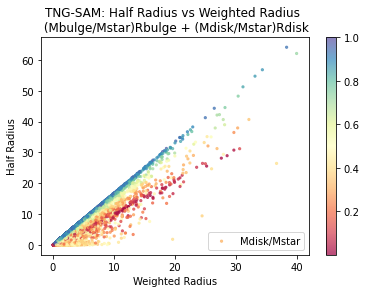

In [30]:
plt.scatter(df_not_normalized.loc[:, 'WeightedRadius2'], df_not_normalized.loc[:, 'GalpropHalfRadius'], 
            c = df_not_normalized.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='Mdisk/Mstar') #, vmin=0.005, vmax=0.04)
plt.xlabel('Weighted Radius')
plt.ylabel('Half Radius')
plt.title('TNG-SAM: Half Radius vs Weighted Radius \n (Mbulge/Mstar)Rbulge + (Mdisk/Mstar)Rdisk')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('TNG_SAM_halfrad_weightedrad2_MdiskMstar.jpeg', dpi=500)
plt.show()

In [27]:
df_14_raw = df_not_normalized.loc[df_not_normalized.BulgeMstar_ratio <= 0.40] 


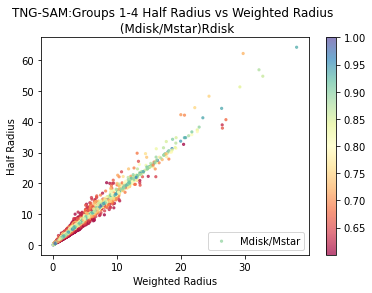

In [33]:
plt.scatter(df_14_raw.loc[:, 'WeightedRadius'], df_14_raw.loc[:, 'GalpropHalfRadius'], 
            c = df_14_raw.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='Mdisk/Mstar') #, vmin=0.005, vmax=0.04)
plt.xlabel('Weighted Radius')
plt.ylabel('Half Radius')
plt.title('TNG-SAM:Groups 1-4 Half Radius vs Weighted Radius \n (Mdisk/Mstar)Rdisk')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('TNG_SAM_Groups14_halfrad_weightedrad_MdiskMstar.jpeg', dpi=500)
plt.show()

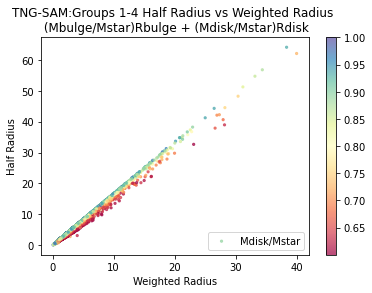

In [32]:
plt.scatter(df_14_raw.loc[:, 'WeightedRadius2'], df_14_raw.loc[:, 'GalpropHalfRadius'], 
            c = df_14_raw.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='Mdisk/Mstar') #, vmin=0.005, vmax=0.04)
plt.xlabel('Weighted Radius')
plt.ylabel('Half Radius')
plt.title('TNG-SAM:Groups 1-4 Half Radius vs Weighted Radius \n (Mbulge/Mstar)Rbulge + (Mdisk/Mstar)Rdisk')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('TNG_SAM_Groups14_halfrad_weightedrad2_MdiskMstar.jpeg', dpi=500)
plt.show()

In [30]:
dfnew = df_not_normalized[(df_not_normalized.GalpropHalfRadius<20) & 
                          (df_not_normalized.WeightedRadius<2)]

In [44]:
dfnew

,GalpropMBH,GalpropMH2,GalpropMHI,GalpropMHII,GalpropMaccdot,GalpropMaccdot_radio,GalpropMbulge,GalpropMcold,GalpropMstar,GalpropMstar_merge,GalpropMstrip,GalpropMu_merger,GalpropMvir,GalpropOutflowRate_Mass,GalpropOutflowRate_Metal,GalpropRbulge,GalpropRdisk,GalpropRedshift,GalpropRfric,GalpropRhalo,GalpropSfr,GalpropSfrave100myr,GalpropSfrave1gyr,GalpropSfrave20myr,GalpropSigmaBulge,GalpropTmerger,GalpropTmerger_major,GalpropTsat,GalpropVdisk,GalpropZcold,GalpropZstar,GalpropX,GalpropVx,GalpropY,GalpropVy,GalpropZ,GalpropVz,HalopropC_nfw,HalopropMaccdot_metal,HalopropMaccdot_pristine,HalopropMaccdot_radio,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate_metal,HalopropMass_ejected,HalopropMcooldot,HalopropMdot_eject,HalopropMdot_eject_metal,HalopropMetal_ejected,HalopropMhot,HalopropMstar_diffuse,HalopropMvir,HalopropSpin,HalopropZhot,GalpropHalfRadius,GalpropLogMstar,GalpropLogHalfRadius,GalpropLogMvir,HalopropLogMhot,GalpropLogMbulge,GalpropLogSfr,GalpropLogSfrave100myr,GalpropLogSfrave1gyr,GalpropLogSfrave20myr,Galprop_neutral_H_mass,Galprop_baryon_mass,Galprop_gas_fraction,HalopropVvir,MstarMvir_ratio,GalpropMdisk,DiskMstar_ratio,WeightedRadius
0,1.301360e+05,0.000000e+00,2.710510e-11,2.283460e+05,0.0,3.504660e-09,7.260470e+07,3.082220e+05,1.050790e+08,1.404410e+06,4.502510e+09,0.288967,4.502510e+09,0.031659,0.000827,0.503721,1.03908,0.0,0.0,0.043502,0.000402,0.000375,0.000458,0.000247,22.1086,4.65438,4.65438,-99.0,21.0336,0.000008,0.004245,16.0668,558.08,1.714200,-65.14,12.5440,78.75,59.1291,0.0,0.0,3.504660e-09,0.341844,0.0,6.824580e+09,3.162250e+07,0.0,0.0,0.114885,9.503960e+09,1.339210e+06,4.502510e+09,0.03378,1.048970e+08,0.829693,8.021516,-0.081083,9.653455,9.977905,7.860965,-3.395986,-3.426001,-3.339338,-3.608164,2.710510e-11,1.050790e+08,2.579497e-19,21.180047,0.023338,3.247430e+07,0.309047,0.321124
1,5.412750e+05,1.455160e+08,4.310100e+08,2.505300e+08,0.0,4.201900e-08,2.312560e+08,1.111490e+09,2.136860e+09,4.105360e+07,1.285310e+11,0.231417,1.285310e+11,2.233340,0.414400,1.340100,1.44021,0.0,0.0,0.132950,0.101277,0.097127,0.146846,0.062210,62.5615,9.17507,113.70200,-99.0,84.1900,0.206532,0.485612,16.2848,364.42,0.534603,166.16,12.5100,68.62,21.8788,0.0,0.0,4.201900e-08,1.571940,0.0,3.167380e+10,1.660060e+09,0.0,0.0,4.052160,8.516240e+05,1.781820e+07,1.285310e+11,0.03407,1.572950e+05,2.332662,9.329776,0.367852,11.109008,5.930248,8.364093,-0.994489,-1.012659,-0.833138,-1.206143,5.765260e+08,2.713386e+09,2.124748e-01,64.730852,0.016625,1.905604e+09,0.891778,1.284347
2,5.801040e+05,4.618540e+07,3.059520e+08,2.233320e+08,0.0,4.726200e-08,2.406350e+08,7.769080e+08,1.583780e+09,1.306340e+07,1.171930e+11,0.246886,1.171930e+11,1.601270,0.205984,1.801320,1.82321,0.0,0.0,0.128920,0.028763,0.026769,0.039126,0.017644,52.0162,12.53960,113.70200,-99.0,62.3345,0.099900,0.308089,17.3583,591.05,0.686448,73.83,11.7006,20.84,23.4472,0.0,0.0,4.726200e-08,1.482840,0.0,2.979890e+10,1.540290e+09,0.0,0.0,3.075050,5.588210e+05,3.570910e+06,1.171930e+11,0.01407,6.596390e+04,2.922134,9.199695,0.465700,11.068902,5.747273,8.381359,-1.541164,-1.572371,-1.407537,-1.753413,3.521374e+08,1.935917e+09,1.818969e-01,62.768620,0.013514,1.343145e+09,0.848063,1.546197
3,1.366780e+06,6.824820e+07,5.498750e+08,3.847350e+08,0.0,1.404620e-07,3.234520e+08,1.352870e+09,1.241640e+09,5.510730e+07,1.705850e+11,0.202695,1.705850e+11,1.620810,0.192479,2.040110,2.30283,0.0,0.0,0.146106,0.042378,0.039515,0.043836,0.025998,53.9346,5.72324,113.70200,-99.0,70.6439,0.160787,0.204719,17.8685,183.70,0.809891,-86.55,12.4072,-43.04,17.7010,0.0,0.0,1.404620e-07,1.290780,0.0,2.596220e+10,1.404660e+09,0.0,0.0,2.342900,1.107320e+06,1.431260e+07,1.705850e+11,0.02229,1.250460e+05,3.491710,9.093996,0.543038,11.231941,6.044273,8.509810,-1.372860,-1.403237,-1.358168,-1.585062,6.181232e+08,1.859763e+09,3.323666e-01,71.135923,0.007279,9.181880e+08,0.739496,1.702934
4,1.450610e+06,2.448120e+07,1.699390e+08,1.440650e+08,0.0,9.336400e-08,4.903280e+08,4.571360e+08,1.432650e+09,2.9152

In [73]:
((dfnew.GalpropHalfRadius == 10) & (dfnew.WeightedRadius==2))

0        False
1        False
2        False
3        False
4        False
         ...  
35381    False
35384    False
35387    False
35388    False
35389    False
Length: 16175, dtype: bool

<AxesSubplot:>

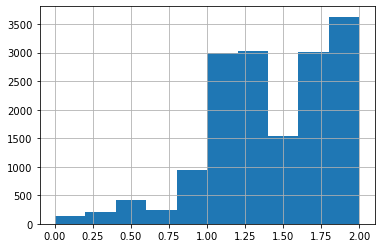

In [80]:
dfnew.WeightedRadius.round(1).hist()

In [88]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 100)

dfnew[((dfnew.GalpropHalfRadius >= 10) & (dfnew.WeightedRadius <=2))]

,GalpropMBH,GalpropMH2,GalpropMHI,GalpropMHII,GalpropMaccdot,GalpropMaccdot_radio,GalpropMbulge,GalpropMcold,GalpropMstar,GalpropMstar_merge,GalpropMstrip,GalpropMu_merger,GalpropMvir,GalpropOutflowRate_Mass,GalpropOutflowRate_Metal,GalpropRbulge,GalpropRdisk,GalpropRedshift,GalpropRfric,GalpropRhalo,GalpropSfr,GalpropSfrave100myr,GalpropSfrave1gyr,GalpropSfrave20myr,GalpropSigmaBulge,GalpropTmerger,GalpropTmerger_major,GalpropTsat,GalpropVdisk,GalpropZcold,GalpropZstar,GalpropX,GalpropVx,GalpropY,GalpropVy,GalpropZ,GalpropVz,HalopropC_nfw,HalopropMaccdot_metal,HalopropMaccdot_pristine,HalopropMaccdot_radio,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate_metal,HalopropMass_ejected,HalopropMcooldot,HalopropMdot_eject,HalopropMdot_eject_metal,HalopropMetal_ejected,HalopropMhot,HalopropMstar_diffuse,HalopropMvir,HalopropSpin,HalopropZhot,GalpropHalfRadius,GalpropLogMstar,GalpropLogHalfRadius,GalpropLogMvir,HalopropLogMhot,GalpropLogMbulge,GalpropLogSfr,GalpropLogSfrave100myr,GalpropLogSfrave1gyr,GalpropLogSfrave20myr,Galprop_neutral_H_mass,Galprop_baryon_mass,Galprop_gas_fraction,HalopropVvir,MstarMvir_ratio,GalpropMdisk,DiskMstar_ratio,WeightedRadius
701,5.956220e+09,2.707610e+09,1.598400e+10,3.413710e+10,0.0,1.044410,4.778940e+11,7.137980e+10,4.985480e+11,4.589310e+11,7.753170e+13,0.255614,7.753170e+13,0.137638,0.245874,14.36570,42.55990,0.0,0.0,1.123340,1.633010,1.507560,9.992940,1.001350,346.707,1.316620,1.316620,-99.0,543.152,127.531000,775.8610,12.34470,18.97,17.504700,36.72,51.10570,-343.99,4.17227,0.0,0.0,1.044410,155.76100,0.0,3.128710e+12,0.0,0.0,0.0,364.3320,1.362540e+13,1.357650e+11,7.753170e+13,0.05358,9.903000e+11,15.403109,11.697707,1.187608,13.889479,13.134349,11.679332,0.212989,0.178275,0.999693,0.000586,1.869161e+10,5.172396e+11,3.613724e-02,546.934259,0.006430,2.065399e+10,0.041428,1.763184
884,7.673640e+08,2.075220e+09,1.002380e+10,8.339130e+09,0.0,0.078917,2.090890e+11,2.760940e+10,2.124370e+11,1.956000e+11,3.212280e+13,0.182202,3.212280e+13,0.265526,0.219480,18.64290,11.84330,0.0,0.0,0.837448,1.292720,1.192360,0.864933,0.792652,246.822,2.235920,5.456320,-99.0,404.917,22.836700,334.4690,6.86975,-3.95,8.173630,184.41,58.35530,-326.02,5.16242,0.0,0.0,0.078917,77.58580,0.0,1.552300e+12,0.0,0.0,0.0,249.9150,6.001840e+12,6.382070e+10,3.212280e+13,0.00677,4.679430e+11,18.677785,11.327230,1.271325,13.506813,12.778284,11.320331,0.111504,0.076407,-0.063018,-0.100917,1.209902e+10,2.245360e+11,5.388454e-02,407.736716,0.006613,3.347992e+09,0.015760,0.186650
1632,8.871630e+09,4.908330e+08,4.459050e+09,1.554680e+10,0.0,1.600100,4.332450e+11,2.769630e+10,4.411030e+11,3.666630e+11,8.374670e+13,0.430774,8.374670e+13,0.023466,0.050760,12.05860,32.04600,0.0,0.0,1.152590,0.294651,0.271987,0.300150,0.180677,357.356,3.936930,3.936930,-99.0,557.293,59.912800,879.3680,9.82848,-106.47,43.706600,-0.75,7.07130,9.87,6.99415,0.0,0.0,1.600100,140.06200,0.0,2.813300e+12,0.0,0.0,0.0,267.1430,1.201830e+13,2.236000e+11,8.374670e+13,0.03932,8.812110e+11,12.411860,11.644540,1.093837,13.922968,13.079843,11.636734,-0.530692,-0.565452,-0.522662,-0.743097,4.949883e+09,4.460529e+11,1.109708e-02,561.174497,0.005267,7.858002e+09,0.017814,0.570881
3026,4.681770e+08,7.420150e+08,8.560210e+09,1.226740e+10,0.0,0.021892,1.649990e+11,2.914330e+10,1.661150e+11,1.631330e+11,1.289190e+13,0.334321,1.289190e+13,0.243089,0.223203,15.92730,19.87420,0.0,0.0,0.617722,0.447469,0.413103,0.415302,0.274385,200.109,2.930830,2.930830,-99.0,298.676,26.764500,363.7530,13.07850,297.74,26.606400,342.14,95.56850,-296.08,7.22750,0.0,0.0,0.022181,23.94760,0.0,6.318510e+11,0.0,0.0,0.0,62.9210,2.362310e+12,4.181310e+10,1.289190e+13,0.04550,1.671820e+11,16.046671,11.220409,1.205385,13.110317,12.373337,11.217481,-0.349237,-0.383942,-0.381636,-0.561640,9.302225e+09,1.754172e+11,5.302914e-02,300.756023,0.012885,1.116013e+09,0.006718,0.133521
3998,5.109870e+09,1.912800e+07,7.506510e+08,1.319690e+10,0.0,0.845752,2.268970e+11,1.887380e+10,2.355240e+11,2.076700e+11,6.513140e+13,0.50

In [91]:
# one example of a galaxy with a HalfRadius =18 but WeightedRadius =1
dfnew.loc[14565,:]


GalpropMBH                          6.626460e+09
GalpropMH2                          8.652820e+09
GalpropMHI                          1.589240e+10
GalpropMHII                         2.990530e+10
GalpropMaccdot                      0.000000e+00
GalpropMaccdot_radio                1.124230e+00
GalpropMbulge                       5.153620e+11
GalpropMcold                        7.354760e+10
GalpropMstar                        5.327220e+11
GalpropMstar_merge                  4.786580e+11
GalpropMstrip                       7.167120e+13
GalpropMu_merger                    5.353610e-01
GalpropMvir                         7.167120e+13
GalpropOutflowRate_Mass             4.824490e-01
GalpropOutflowRate_Metal            1.043180e+00
GalpropRbulge                       1.750560e+01
GalpropRdisk                        3.161680e+01
GalpropRedshift                     0.000000e+00
GalpropRfric                        0.000000e+00
GalpropRhalo                        1.094300e+00
GalpropSfr          

In [70]:

dfnew['GalpropHalfRadius'].value_counts()

3.964972    1
3.225953    1
2.821247    1
1.735197    1
2.428386    1
           ..
1.936613    1
2.279984    1
2.285171    1
1.774226    1
0.161864    1
Name: GalpropHalfRadius, Length: 16175, dtype: int64

In [66]:
dfnew.loc[:, 'WeightedRadius'].describe()

count    16175.000000
mean         1.410119
std          0.398520
min          0.000334
25%          1.180940
50%          1.457446
75%          1.720987
max          1.999911
Name: WeightedRadius, dtype: float64

In [43]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 100)

dfnew.loc[35387,:]

GalpropMBH                          1.402810e+05
GalpropMH2                          7.508750e+07
GalpropMHI                          4.174370e+08
GalpropMHII                         2.042310e+08
GalpropMaccdot                      0.000000e+00
GalpropMaccdot_radio                2.262000e-08
GalpropMbulge                       2.044020e+07
GalpropMcold                        9.392910e+08
GalpropMstar                        1.227350e+08
GalpropMstar_merge                  8.325890e+06
GalpropMstrip                       5.175670e+10
GalpropMu_merger                    2.151270e-01
GalpropMvir                         5.175670e+10
GalpropOutflowRate_Mass             2.181900e+00
GalpropOutflowRate_Metal            6.097210e-02
GalpropRbulge                       5.538820e-01
GalpropRdisk                        1.156710e+00
GalpropRedshift                     0.000000e+00
GalpropRfric                        0.000000e+00
GalpropRhalo                        9.817680e-02
GalpropSfr          

## <font color='darkred'> TNG-SIM

In [18]:
# read TNG-SIM (simulation) dataset
df_sim = pd.read_hdf ('./tng-sim.h5') 

In [19]:
df_sim

,SubhaloBHMass,SubhaloBHMdot,SubhaloGasMetallicity,SubhaloMass,SubhaloSFRinRad,SubhaloStarMetallicity,SubhaloVmax,SubhaloVmaxRad,SubhaloRgas,SubhaloRstar,...,Group_M_Crit200,Group_M_TopHat200,Group_R_Crit200,Group_R_TopHat200,GroupX,GroupVx,GroupY,GroupVy,GroupZ,GroupVz
0,9.956542e+09,0.000398,0.007718,3.903116e+14,0.195825,0.028622,999.385132,327.828064,891.066223,67.312584,...,3.625763e+14,4.435949e+14,1.465438e+13,1.959449e+13,1.206096,39.461819,37.396305,-149.214828,26.004168,31.337929
1,1.782920e+09,0.000230,0.008247,5.208271e+13,0.088085,0.021265,514.775879,376.200653,523.474487,24.165314,...,3.625763e+14,4.435949e+14,1.465438e+13,1.959449e+13,1.206096,39.461819,37.396305,-149.214828,26.004168,31.337929
2,2.521123e+09,0.001054,0.011213,1.098658e+13,5.294215,0.025407,461.641266,70.981499,70.518997,21.284046,...,3.625763e+14,4.435949e+14,1.465438e+13,1.959449e+13,1.206096,39.461819,37.396305,-149.214828,26.004168,31.337929
3,4.888925e+08,0.000051,0.020788,4.817231e+12,2.142880,0.023964,291.936554,2.308248,165.368149,9.275959,...,3.625763e+14,4.435949e+14,1.465438e+13,1.959449e+13,1.206096,39.461819,37.396305,-149.214828,26.004168,31.337929
4,7.420399e+08,0.000047,0.013132,4.621686e+12,0.283784,0.020044,294.432983,42.098446,81.432083,12.771088,...,3.625763e+14,4.435949e+14,1.465438e+13,1.959449e+13,1.206096,39.461819,37.396305,-149.214828,26.004168,31.337929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4371206,0.000000e+00,0.000000,0.000000,2.010807e+08,0.000000,0.000000,8.586166,3.245162,0.000000,0.000000,...,1.364476e+08,1.938992e+08,1.058027e+11,1.487130e+11,101.206451,179.564926,93.423424,-116.401894,100.198311,-182.063950
4371207,0.000000e+00,0.000000,0.000000,2.082621e+08,0.000000,0.000000,10.621514,1.349483,0.000000,0.000000,...,1.301106e+08,1.444735e+08,1.041386e+11,1.348177e+11,105.215202,289.693726,57.596630,94.790306,50.515755,-46.963703
4371208,0.000000e+00,0.000000,0.000000,2.154436e+08,0.000000,0.000000,13.217928,1.244846,0.000000,0.000000,...,1.882869e+08,2.098313e+08,1.177882e+11,1.526746e+11,99.450386,109.815811,29.580376,289.188477,99.564903,165.845825
4371209,0.000000e+00,0.000000,0.000000,2.082621e+08,0.000000,0.000000,9.830630,2.925654,0.000000,0.000000,...,1.723549e+08,1.795363e+08,1.143647e+11,1.449456e+11,101.735069,180.064240,33.906242,35.809826,73.331772,-16.962486


In [20]:
# Remove all galaxies with logMstar < 8
df_sim = df_sim[df_sim.SubhaloMstar>1e8]

In [21]:
df_sim.shape

(46423, 31)

In [22]:
# Define Halo property Vvir (as it does not exist in the dataset above)
v_sim = Mvir_to_Vvir (np.array(df_sim.loc[:,'SubhaloMass']),0) # has units

In [23]:
v_sim

<Quantity [937.37312927, 479.00481394, 285.14312927, ...,   7.0333748 ,
             7.12726705,   6.91962152] km / s>

In [24]:
# add Halo property Vvir
df_sim.loc[:, 'SubhaloVvir']=v_sim.value 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [25]:
df_sim.shape

(46423, 32)

In [26]:
df_sim.SubhaloMstar.max()

3143714000000.0

In [27]:
# Correct values of Rvir
df_sim.loc[:, 'Group_R_Crit200_corr']=df_sim.loc[:, 'Group_R_Crit200']/1e10

In [28]:
df_sim.columns.to_list()

['SubhaloBHMass',
 'SubhaloBHMdot',
 'SubhaloGasMetallicity',
 'SubhaloMass',
 'SubhaloSFRinRad',
 'SubhaloStarMetallicity',
 'SubhaloVmax',
 'SubhaloVmaxRad',
 'SubhaloRgas',
 'SubhaloRstar',
 'SubhaloMgas',
 'SubhaloMstar',
 'SubhaloX',
 'SubhaloJx',
 'SubhaloY',
 'SubhaloJy',
 'SubhaloZ',
 'SubhaloJz',
 'GroupBHMass',
 'GroupMass',
 'GroupNsubs',
 'Group_M_Crit200',
 'Group_M_TopHat200',
 'Group_R_Crit200',
 'Group_R_TopHat200',
 'GroupX',
 'GroupVx',
 'GroupY',
 'GroupVy',
 'GroupZ',
 'GroupVz',
 'SubhaloVvir',
 'Group_R_Crit200_corr']

#### Add spin to TNG-SIM: lambda = sqrt(Jx^2 + Jy^2 + Jz^2) /over sqrt(2) Mvir Rvir.

In [29]:
def spin_func(jx, jy, jz, Mvir, Rvir, Vvir):
    
#     spin = np.sqrt(jx**2 + jy**2 + jz**2)/(np.sqrt(2)*Mvir*Rvir*Vvir)
    spin = np.sqrt(jx**2 + jy**2 + jz**2)/(np.sqrt(2)*Rvir*Vvir)
   
    # Spin from TNG-SIM has units kpc*km/s which is not J or spin. 
    # It would indicate that it is J/M (it is specific spin; spin per mass). 
    # Therefore, do not divide by Mvir in the formula.

    return spin
    

In [30]:

df_sim.loc[:,'SubhaloSpin'] = df_sim.apply(lambda x: spin_func(jx=x['SubhaloJx'],
                                                                         jy=x['SubhaloJy'],
                                                                         jz=x['SubhaloJz'],
                                                                         Mvir=x['SubhaloMass'],
                                                                         Rvir=x['Group_R_Crit200_corr'],
                                                                         Vvir=x['SubhaloVvir']), axis=1)

In [31]:
df_sim.shape

(46423, 34)

In [32]:
df_sim.loc[:,'SubhaloLogMstar']=df_sim.loc[:,'SubhaloMstar'].apply(lambda x: np.log10(x) if x>0 else 0)


In [33]:
df_sim.loc[:,'SubhaloLogRstar']=df_sim.loc[:,'SubhaloRstar'].apply(lambda x: np.log10(x) if x>0 else 0)



In [34]:
df_sim.columns.to_list()

['SubhaloBHMass',
 'SubhaloBHMdot',
 'SubhaloGasMetallicity',
 'SubhaloMass',
 'SubhaloSFRinRad',
 'SubhaloStarMetallicity',
 'SubhaloVmax',
 'SubhaloVmaxRad',
 'SubhaloRgas',
 'SubhaloRstar',
 'SubhaloMgas',
 'SubhaloMstar',
 'SubhaloX',
 'SubhaloJx',
 'SubhaloY',
 'SubhaloJy',
 'SubhaloZ',
 'SubhaloJz',
 'GroupBHMass',
 'GroupMass',
 'GroupNsubs',
 'Group_M_Crit200',
 'Group_M_TopHat200',
 'Group_R_Crit200',
 'Group_R_TopHat200',
 'GroupX',
 'GroupVx',
 'GroupY',
 'GroupVy',
 'GroupZ',
 'GroupVz',
 'SubhaloVvir',
 'Group_R_Crit200_corr',
 'SubhaloSpin',
 'SubhaloLogMstar',
 'SubhaloLogRstar']

In [35]:
df_sim.SubhaloLogMstar.max()

12.497443021906225

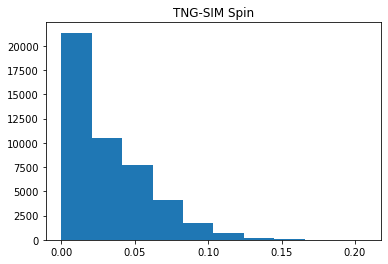

In [36]:
plt.hist(df_sim.loc[:, 'SubhaloSpin']) #, range=(0, 0.5e-20))
plt.title('TNG-SIM Spin')
# plt.savefig('TNG-SIM_spin.jpeg', dpi=500)
plt.show()

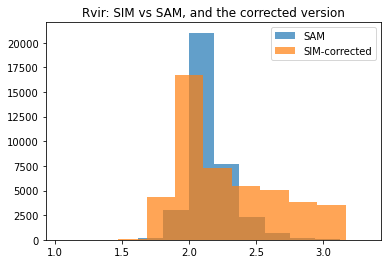

In [37]:
# plt.hist(np.log10(df_sim.loc[:, 'Group_R_Crit200']), label='SIM', alpha=0.7) 
plt.hist(np.log10(df_not_normalized.loc[:, 'GalpropRhalo']*1000), label='SAM', alpha=0.7)#, range=(0, 30))
plt.hist(np.log10(df_sim.loc[:, 'Group_R_Crit200_corr']), label='SIM-corrected', alpha=0.7) 
plt.title('Rvir: SIM vs SAM, and the corrected version')
plt.legend()
plt.show()

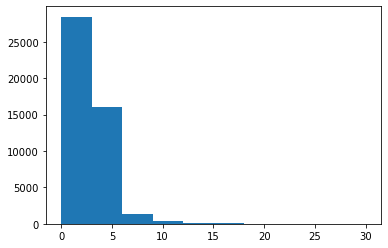

In [38]:
plt.hist(df_sim.loc[:, 'SubhaloRstar'], range=(0, 30))
plt.show()

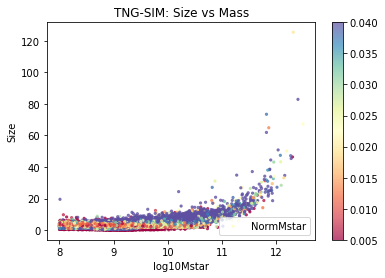

In [39]:
plt.scatter(np.log10(df_sim.loc[:, 'SubhaloMstar']), df_sim.loc[:, 'SubhaloRstar'],
            c = df_sim.loc[:,'SubhaloSpin'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormMstar', vmin=0.005, vmax=0.04)
plt.xlabel('log10Mstar')
plt.ylabel('Size')
plt.title('TNG-SIM: Size vs Mass')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('TNG_SIM_size_mass.jpeg', dpi=500)
plt.show()

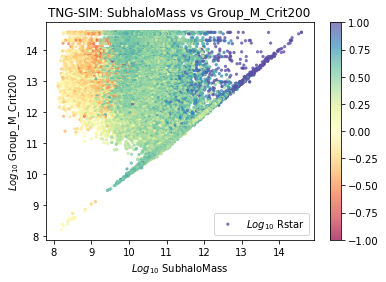

In [40]:
plt.scatter(np.log10(df_sim.loc[:, 'SubhaloMass']), np.log10(df_sim.loc[:, 'Group_M_Crit200']),
            c = np.log10(df_sim.loc[:,'SubhaloRstar']),  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='$ Log_{10} $ Rstar', vmin=-1.0, vmax=1.0)
plt.xlabel('$ Log_{10} $ SubhaloMass')
plt.ylabel('$ Log_{10} $ Group_M_Crit200')
plt.title('TNG-SIM: SubhaloMass vs Group_M_Crit200')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('TNG-SIM_SubhaloMass_vs_Group_M_Crit200.jpeg', dpi=500)
plt.show()

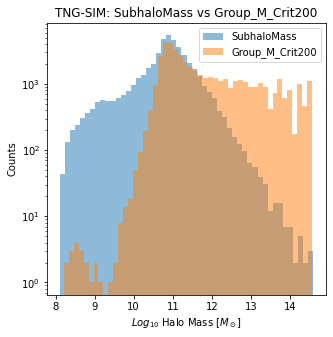

In [41]:
fig1,(ax1)=plt.subplots(nrows=1,ncols=1,figsize=(5,5))

ax1.hist(np.log10(df_sim.loc[:,'SubhaloMass']), bins=50, log=True, alpha=0.5, label='SubhaloMass')
ax1.hist(np.log10(df_sim.loc[:,'Group_M_Crit200']), bins=50, log=True, alpha=0.5, label='Group_M_Crit200')
ax1.set_title('TNG-SIM: SubhaloMass vs Group_M_Crit200')
ax1.set_xlabel('$ Log_{10} $ Halo Mass [$ M_\odot $]')
ax1.set_ylabel('Counts')
ax1.legend(loc='upper right')

# plt.savefig("TNG-SIM_SubhaloMass_vs_Group_M_crit200_Hist1D.jpeg", dpi=500)
plt.show()

## <font color='darkblue'> TNG SIM vs SAM histograms

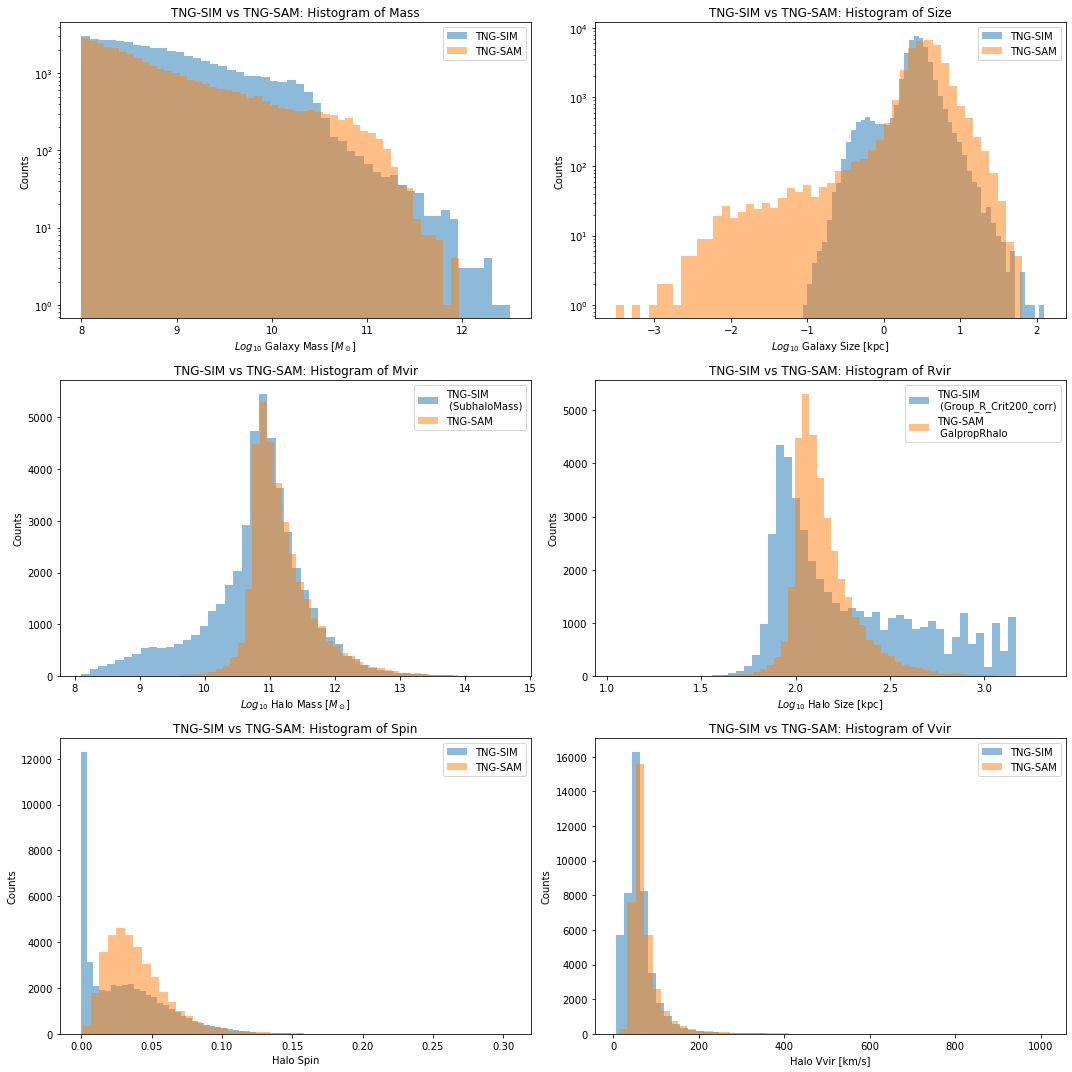

In [42]:
fig,[(ax1, ax2), (ax3, ax4), (ax5, ax6)]=plt.subplots(nrows=3,ncols=2,figsize=(15,15))

ax1.hist(np.log10(df_sim.loc[:, 'SubhaloMstar']), bins=50, log=True, alpha=0.5, label='TNG-SIM')
ax1.hist(df_not_normalized.loc[:, 'GalpropLogMstar'], bins=50, log=True, alpha=0.5, label='TNG-SAM')
ax1.set_title('TNG-SIM vs TNG-SAM: Histogram of Mass')
ax1.set_xlabel('$ Log_{10} $ Galaxy Mass [$ M_\odot $]')
ax1.set_ylabel('Counts')
ax1.legend(loc='upper right')

ax2.hist(np.log10(df_sim.loc[:, 'SubhaloRstar']),bins=50, log=True, alpha=0.5, label='TNG-SIM')
ax2.hist(np.log10(df_not_normalized.loc[:, 'GalpropHalfRadius']), bins=50, log=True, alpha=0.5, label='TNG-SAM')
ax2.set_title('TNG-SIM vs TNG-SAM: Histogram of Size')
ax2.set_xlabel('$ Log_{10} $ Galaxy Size [kpc]')
ax2.set_ylabel('Counts')
ax2.legend(loc='upper right')

ax3.hist(np.log10(df_sim.loc[:, 'SubhaloMass']), bins=50, alpha=0.5, label='TNG-SIM \n (SubhaloMass)')
ax3.hist(np.log10(df_not_normalized.loc[:, 'HalopropMvir']), bins=50, alpha=0.5, label='TNG-SAM')
ax3.set_title('TNG-SIM vs TNG-SAM: Histogram of Mvir')
ax3.set_xlabel('$ Log_{10} $ Halo Mass [$ M_\odot $]')
ax3.set_ylabel('Counts')
ax3.legend(loc='upper right')

ax4.hist(np.log10(df_sim.loc[:, 'Group_R_Crit200_corr']), bins=50, alpha=0.5, label='TNG-SIM \n (Group_R_Crit200_corr)')
# multiply GalpropRhalo by 1000 to convert from Mpc to kpc
ax4.hist(np.log10(df_not_normalized.loc[:, 'GalpropRhalo']*1000), bins=50, alpha=0.5, label='TNG-SAM \n GalpropRhalo')
ax4.set_title('TNG-SIM vs TNG-SAM: Histogram of Rvir')
ax4.set_xlabel('$ Log_{10} $ Halo Size [kpc]')
ax4.set_ylabel('Counts')
ax4.legend(loc='upper right')

ax5.hist(df_sim.loc[:, 'SubhaloSpin'], bins=50, alpha=0.5, label='TNG-SIM')
ax5.hist(df_not_normalized.loc[:, 'HalopropSpin'], bins=50, alpha=0.5, label='TNG-SAM')
ax5.set_title('TNG-SIM vs TNG-SAM: Histogram of Spin')
ax5.set_xlabel('Halo Spin')
ax5.set_ylabel('Counts')
ax5.legend(loc='upper right')

ax6.hist(df_sim.loc[:, 'SubhaloVvir'], bins=50, alpha=0.5, label='TNG-SIM')
ax6.hist(df_not_normalized.loc[:, 'HalopropVvir'], bins=50, alpha=0.5, label='TNG-SAM')
ax6.set_title('TNG-SIM vs TNG-SAM: Histogram of Vvir')
ax6.set_xlabel('Halo Vvir [km/s]')
ax6.set_ylabel('Counts')
ax6.legend(loc='upper right')

# def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
#     "Sign sets of subplots with title"
#     row = fig.add_subplot(grid)
#     # the '\n' is important
#     row.set_title(f'{title}\n', fontweight='semibold')
#     # hide subplot
#     row.set_frame_on(False)
#     row.axis('off')
    
# grid = plt.GridSpec(2, 2)
# create_subtitle(fig, grid[0, ::], 'Central Galaxies')
# create_subtitle(fig, grid[1, ::], 'Satellite Galaxies')
fig.tight_layout()
# plt.savefig("TNG-SIM_vs_TNG-SAM_histograms_mass_size_halomass_size_spin_vvir.jpeg", dpi=500)
plt.show()

## <font color='darkblue'> TNG SIM vs SAM: size mass plot

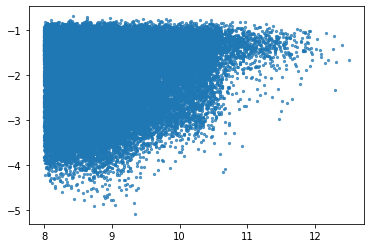

In [43]:
plt.scatter(np.log10(df_sim.loc[:, 'SubhaloMstar']), np.log10(df_sim.loc[:,'SubhaloSpin']),
           s=20, marker='.', alpha=0.7, label='SIM')
plt.show()

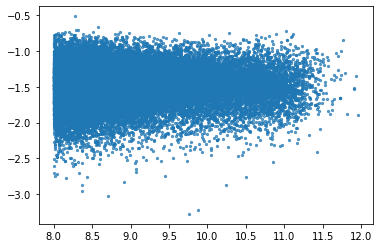

In [44]:
plt.scatter(df_not_normalized.loc[:, 'GalpropLogMstar'], np.log10(df_not_normalized.loc[:,'HalopropSpin']),
           s=20, marker='.', alpha=0.7, label='SIM')
plt.show()

##### Conclusion of above plots: Very low spin galaxies span all mass ranges

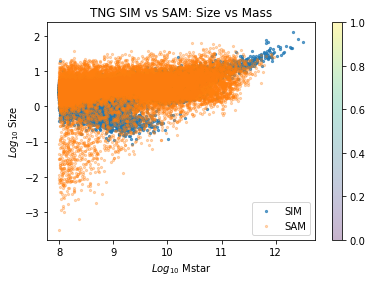

In [45]:


plt.scatter(np.log10(df_sim.loc[:, 'SubhaloMstar']), np.log10(df_sim.loc[:,'SubhaloRstar']),
           s=20, marker='.', alpha=0.7, label='SIM')
plt.scatter(df_not_normalized.loc[:, 'GalpropLogMstar'], np.log10(df_not_normalized.loc[:, 'GalpropHalfRadius']),
           s=20, marker='.', alpha=0.3, label='SAM') 
plt.xlabel('$ Log_{10} $ Mstar')
plt.ylabel('$ Log_{10} $ Size')
plt.title('TNG SIM vs SAM: Size vs Mass')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('TNG-SIM_SubhaloMass_vs_Group_M_Crit200.jpeg', dpi=500)
plt.show()

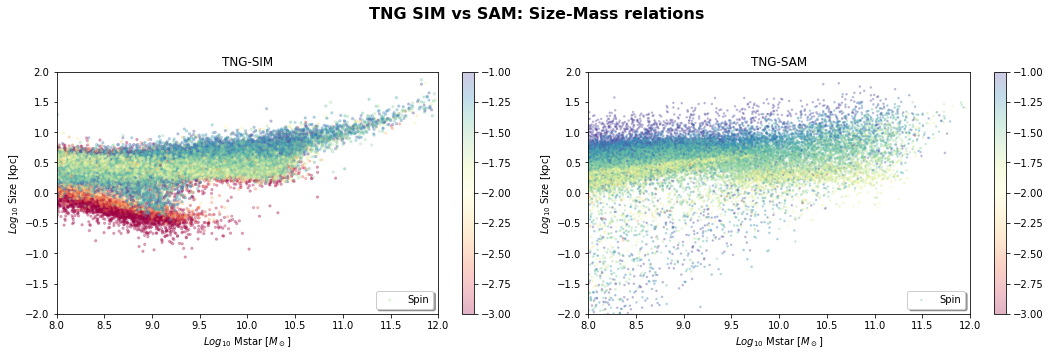

In [46]:
fig_all,[ax1, ax2]=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
fig_all.suptitle('TNG SIM vs SAM: Size-Mass relations', fontsize=16, fontweight='bold')


fig_1 = ax1.scatter(np.log10(df_sim.loc[:, 'SubhaloMstar']), np.log10(df_sim.loc[:,'SubhaloRstar']),
            c = np.log10(df_sim.loc[:,'SubhaloSpin']),  cmap='Spectral',
            s=20, marker='.', alpha=0.3, label='Spin', vmin=-3.0, vmax=-1)
ax1.set_title('TNG-SIM')
ax1.set_xlabel('$ Log_{10} $ Mstar $[M_\odot]$')
ax1.set_ylabel('$ Log_{10} $ Size [kpc] ')
ax1.set_xlim([8.0,12.0])
ax1.set_ylim([-2.0,2.0])
ax1.legend(loc = 'lower right', shadow=True)
fig_all.colorbar(fig_1, ax=ax1)

fig_2 = ax2.scatter(df_not_normalized.loc[:, 'GalpropLogMstar'], np.log10(df_not_normalized.loc[:, 'GalpropHalfRadius']),
            c = np.log10(df_not_normalized.loc[:,'HalopropSpin']),  cmap='Spectral',
            s=10, marker='.', alpha=0.3,label='Spin', vmin=-3.0, vmax=-1)
ax2.set_title('TNG-SAM')
ax2.set_xlabel('$ Log_{10} $ Mstar $[M_\odot]$')
ax2.set_ylabel('$ Log_{10} $ Size [kpc] ')
ax2.set_xlim([8.0,12.0])
ax2.set_ylim([-2.0,2.0])
ax2.legend(loc = 'lower right', shadow=True)
fig_all.colorbar(fig_2, ax=ax2)

fig_all.tight_layout()
fig_all.subplots_adjust(top=0.8, hspace=0.4) #, wspace=0.4)

# plt.savefig("TNG-SIM-SAM_Size_vs_Mass.jpeg", dpi=500)
plt.show()

## <font color='darkviolet'> TNG SIM & SAM: Divide dataset by LogMstar bins

### <font color='darkviolet'> TNG SIM

In [47]:
df_sim_8_9 = df_sim[df_sim.SubhaloLogMstar < 9.0]

In [48]:
df_sim_8_9.shape

(27482, 36)

In [49]:
df_sim_9_10 = df_sim[(df_sim.SubhaloLogMstar >= 9.0) & (df_sim.SubhaloLogMstar < 10.0)]

In [50]:
df_sim_9_10.shape

(13947, 36)

In [51]:
df_sim_10_11 = df_sim[(df_sim.SubhaloLogMstar >= 10.0) & (df_sim.SubhaloLogMstar < 11.0)]

In [52]:
df_sim_10_11.shape

(4642, 36)

In [53]:
df_sim_11_12 = df_sim[(df_sim.SubhaloLogMstar >= 11.0) & (df_sim.SubhaloLogMstar < 12.0)]

In [54]:
df_sim_11_12.shape

(338, 36)

In [55]:
df_sim_11_12.loc[:, 'SubhaloLogMstar'].max()

11.964789059881648

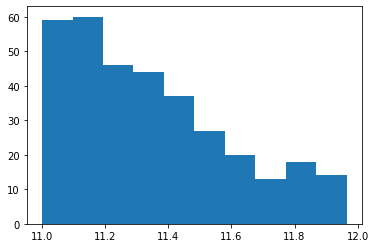

In [95]:
plt.hist(df_sim_11_12.loc[:, 'SubhaloLogMstar'])
plt.show()

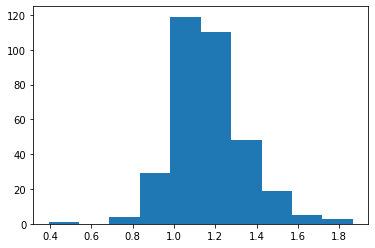

In [118]:
plt.hist(df_sim_11_12.loc[:, 'SubhaloLogRstar'])
plt.show()

### <font color='darkviolet'> TNG SAM

In [56]:
df_sam_8_9 = df_not_normalized[df_not_normalized.GalpropLogMstar < 9.0]

In [57]:
df_sam_8_9.shape

(22913, 68)

In [58]:
df_sam_9_10 = df_not_normalized[(df_not_normalized.GalpropLogMstar >= 9.0) &
                                (df_not_normalized.GalpropLogMstar < 10.0)]

In [59]:
df_sam_9_10.shape

(8108, 68)

In [60]:
df_sam_10_11 = df_not_normalized[(df_not_normalized.GalpropLogMstar >= 10.0) &
                                (df_not_normalized.GalpropLogMstar < 11.0)]

In [61]:
df_sam_10_11.shape

(3745, 68)

In [62]:
df_sam_11_12 = df_not_normalized[(df_not_normalized.GalpropLogMstar >= 11.0) &
                                (df_not_normalized.GalpropLogMstar < 12.0)]

In [63]:
df_sam_11_12.shape

(602, 68)

In [64]:
df_sam_11_12.loc[:, 'GalpropLogMstar'].max()

11.960913422974704

### <font color='darkviolet'> TNG SIM & SAM: Find mean Mstar value for each bin

#### <font color='darkviolet'> TNG SIM

In [65]:
# mean Log Mstar in bin 8-9
sim_mMstar_8_9 = np.mean(df_sim_8_9.loc[:, 'SubhaloLogMstar'])
print(sim_mMstar_8_9)

8.462062537316111


In [66]:
sim_mMstar_9_10 = np.mean(df_sim_9_10.loc[:, 'SubhaloLogMstar'])
print(sim_mMstar_9_10)

9.427741151769462


In [67]:
sim_mMstar_10_11 = np.mean(df_sim_10_11.loc[:, 'SubhaloLogMstar'])
print(sim_mMstar_10_11)

10.307819325353032


In [68]:
sim_mMstar_11_12 = np.mean(df_sim_11_12.loc[:, 'SubhaloLogMstar'])
print(sim_mMstar_11_12)

11.347388256267726


In [82]:
# std Log Mstar in bin 8-9
sim_stdMstar_8_9 = np.std(df_sim_8_9.loc[:, 'SubhaloLogMstar'])
print(sim_stdMstar_8_9)

0.2863458346092541


In [83]:
sim_stdMstar_9_10 = np.std(df_sim_9_10.loc[:, 'SubhaloLogMstar'])
print(sim_stdMstar_9_10)

0.2854949099510245


In [84]:
sim_stdMstar_10_11 = np.std(df_sim_10_11.loc[:, 'SubhaloLogMstar'])
print(sim_stdMstar_10_11)

0.22313741120677316


In [85]:
sim_stdMstar_11_12 = np.std(df_sim_11_12.loc[:, 'SubhaloLogMstar'])
print(sim_mMstar_11_12)

11.347388256267726


In [69]:
# mean Log Size in bin 8-9
sim_mRstar_8_9 = np.mean(df_sim_8_9.loc[:, 'SubhaloLogRstar'])
print(sim_mRstar_8_9)

0.3585101951883868


In [70]:
sim_mRstar_9_10 = np.mean(df_sim_9_10.loc[:, 'SubhaloLogRstar'])
print(sim_mRstar_9_10)

0.42248018275344984


In [71]:
sim_mRstar_10_11 = np.mean(df_sim_10_11.loc[:, 'SubhaloLogRstar'])
print(sim_mRstar_10_11)

0.6218796276370628


In [72]:
sim_mRstar_11_12 = np.mean(df_sim_11_12.loc[:, 'SubhaloLogRstar'])
print(sim_mRstar_11_12)

1.1709625931524466


In [119]:
# std Log Rstar in bin 8-9
sim_stdRstar_8_9 = np.std(df_sim_8_9.loc[:, 'SubhaloLogRstar'])
print(sim_stdRstar_8_9)

sim_stdRstar_9_10 = np.std(df_sim_9_10.loc[:, 'SubhaloLogRstar'])
print(sim_stdRstar_9_10)

sim_stdRstar_10_11 = np.std(df_sim_10_11.loc[:, 'SubhaloLogRstar'])
print(sim_stdRstar_10_11)

sim_stdRstar_11_12 = np.std(df_sim_11_12.loc[:, 'SubhaloLogRstar'])
print(sim_stdRstar_11_12)

0.2257312638091778
0.25527933698447086
0.2197358232654825
0.17686085672772675


#### <font color='darkviolet'> TNG SAM

In [73]:
# mean Log Mstar in bin 8-9
sam_mMstar_8_9 = np.mean(df_sam_8_9.loc[:, 'GalpropLogMstar'])
print(sam_mMstar_8_9)

8.40789382197904


In [74]:
sam_mMstar_9_10 = np.mean(df_sam_9_10.loc[:, 'GalpropLogMstar'])
print(sam_mMstar_9_10)

9.433364649506876


In [75]:
sam_mMstar_10_11 = np.mean(df_sam_10_11.loc[:, 'GalpropLogMstar'])
print(sam_mMstar_10_11)

10.44923500226935


In [76]:
sam_mMstar_11_12 = np.mean(df_sam_11_12.loc[:, 'GalpropLogMstar'])
print(sam_mMstar_11_12)

11.197974824827151


In [86]:
# std Log Mstar in bin 8-9
sam_stdMstar_8_9 = np.std(df_sam_8_9.loc[:, 'GalpropLogMstar'])
print(sam_stdMstar_8_9)

0.2780583319546748


In [87]:
sam_stdMstar_9_10 = np.std(df_sam_9_10.loc[:, 'GalpropLogMstar'])
print(sam_stdMstar_9_10)

0.28586935808436487


In [88]:
sam_stdMstar_10_11 = np.std(df_sam_10_11.loc[:, 'GalpropLogMstar'])
print(sam_stdMstar_10_11)

0.27963305248699305


In [89]:
sam_stdMstar_11_12 = np.std(df_sam_11_12.loc[:, 'GalpropLogMstar'])
print(sam_stdMstar_11_12)

0.1723862701480985


In [78]:
# mean Log Rstar in bin 8-9
sam_mRstar_8_9 = np.mean(df_sam_8_9.loc[:, 'GalpropLogHalfRadius'])
print(sam_mRstar_8_9)

0.4780468151207077


In [79]:
sam_mRstar_9_10 = np.mean(df_sam_9_10.loc[:, 'GalpropLogHalfRadius'])
print(sam_mRstar_9_10)

0.5685443979734294


In [80]:
sam_mRstar_10_11 = np.mean(df_sam_10_11.loc[:, 'GalpropLogHalfRadius'])
print(sam_mRstar_10_11)

0.6460485724661776


In [81]:
sam_mRstar_11_12 = np.mean(df_sam_11_12.loc[:, 'GalpropLogHalfRadius'])
print(sam_mRstar_11_12)

0.8453778242297865


In [116]:
# std Log Rstar in bin 8-9
sam_stdRstar_8_9 = np.std(df_sam_8_9.loc[:, 'GalpropLogHalfRadius'])
print(sam_stdRstar_8_9)

sam_stdRstar_9_10 = np.std(df_sam_9_10.loc[:, 'GalpropLogHalfRadius'])
print(sam_stdRstar_9_10)

sam_stdRstar_10_11 = np.std(df_sam_10_11.loc[:, 'GalpropLogHalfRadius'])
print(sam_stdRstar_10_11)

sam_stdRstar_11_12 = np.std(df_sam_11_12.loc[:, 'GalpropLogHalfRadius'])
print(sam_stdRstar_11_12)

0.35583581419629967
0.3252453656399986
0.3440825876526135
0.35498557762946564


#### Arrays

In [97]:
sim_mMstar = np.array([sim_mMstar_8_9, sim_mMstar_9_10, sim_mMstar_10_11, sim_mMstar_11_12])

In [111]:
sim_mMstar

array([ 8.46206254,  9.42774115, 10.30781933, 11.34738826])

In [98]:
sim_stdMstar = np.array([sim_stdMstar_8_9, sim_stdMstar_9_10, sim_stdMstar_10_11, sim_stdMstar_11_12])

In [101]:
sim_mRstar = np.array([sim_mRstar_8_9, sim_mRstar_9_10, sim_mRstar_10_11, sim_mRstar_11_12])

In [102]:
sim_mRstar

array([0.3585102 , 0.42248018, 0.62187963, 1.17096259])

In [122]:
sim_stdRstar = np.array([sim_stdRstar_8_9, sim_stdRstar_9_10, sim_stdRstar_10_11, sim_stdRstar_11_12])

In [123]:
sim_stdRstar

array([0.22573126, 0.25527934, 0.21973582, 0.17686086])

In [104]:
sam_mMstar = np.array([sam_mMstar_8_9, sam_mMstar_9_10, sam_mMstar_10_11, sam_mMstar_11_12])

In [112]:
sam_mMstar

array([ 8.40789382,  9.43336465, 10.449235  , 11.19797482])

In [105]:
sam_stdMstar = np.array([sam_stdMstar_8_9, sam_stdMstar_9_10, sam_stdMstar_10_11, sam_stdMstar_11_12])

In [106]:
sam_mRstar = np.array([sam_mRstar_8_9, sam_mRstar_9_10, sam_mRstar_10_11, sam_mRstar_11_12])

In [120]:
sam_stdRstar = np.array([sam_stdRstar_8_9, sam_stdRstar_9_10, sam_stdRstar_10_11, sam_stdRstar_11_12])

In [121]:
sam_stdRstar

array([0.35583581, 0.32524537, 0.34408259, 0.35498558])

In [110]:
sam_mRstar

array([0.47804682, 0.5685444 , 0.64604857, 0.84537782])

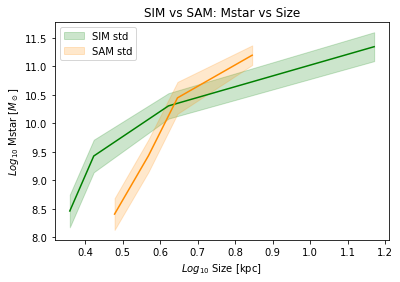

In [128]:
plt.plot(sim_mRstar, sim_mMstar, '-', color='green')

plt.fill_between(sim_mRstar, sim_mMstar - sim_stdMstar, sim_mMstar + sim_stdMstar,
                 color='green', alpha=0.2, label='SIM std')

plt.plot(sam_mRstar, sam_mMstar, '-', color='darkorange')

plt.fill_between(sam_mRstar, sam_mMstar - sam_stdMstar, sam_mMstar + sam_stdMstar,
                 color='darkorange', alpha=0.2, label='SAM std')

plt.title('SIM vs SAM: Mstar vs Size')
plt.ylabel('$ Log_{10} $ Mstar $[M_\odot]$')
plt.xlabel('$ Log_{10} $ Size [kpc] ')
plt.legend()
plt.show()


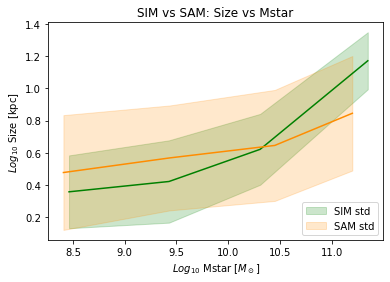

In [129]:
plt.plot(sim_mMstar, sim_mRstar, '-', color='green')

plt.fill_between(sim_mMstar, sim_mRstar - sim_stdRstar, sim_mRstar + sim_stdRstar,
                 color='green', alpha=0.2, label='SIM std')

plt.plot(sam_mMstar, sam_mRstar, '-', color='darkorange')

plt.fill_between(sam_mMstar, sam_mRstar - sam_stdRstar, sam_mRstar + sam_stdRstar,
                 color='darkorange', alpha=0.2, label='SAM std')

plt.title('SIM vs SAM: Size vs Mstar')
plt.xlabel('$ Log_{10} $ Mstar $[M_\odot]$')
plt.ylabel('$ Log_{10} $ Size [kpc] ')
plt.legend(loc='lower right')
# plt.savefig('SIM_SAM_Size_vs_Mstar_w_std.jpeg', dpi=500)
plt.show()

## <font color='darkred'> Check the relation of NormVdik=Vdisk/Vvir vs C_nfw

(array([20617.,  6881.,  2625.,  1477.,   857.,   627.,   469.,   375.,
          308.,   229.,   174.,   124.,   110.,    95.,    75.,    66.,
           51.,    50.,    35.,    25.]),
 array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
        0.09 , 0.095, 0.1  ]),
 <BarContainer object of 20 artists>)

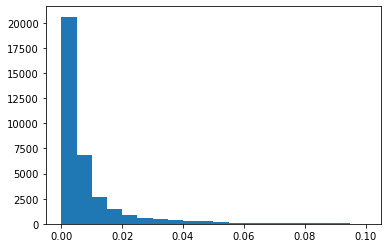

In [32]:
plt.hist(df_normalized_31.loc[:,'GalpropNormMstar'], range=[0,0.1],bins=20)

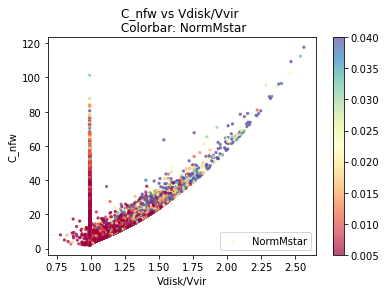

In [33]:
plt.scatter(df_normalized_31.loc[:, 'GalpropNormVdisk'], df_normalized_31.loc[:, 'HalopropC_nfw'],
            c = df_normalized_31.loc[:,'GalpropNormMstar'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormMstar', vmin=0.005, vmax=0.04)
plt.xlabel('Vdisk/Vvir')
plt.ylabel('C_nfw')
plt.title('C_nfw vs Vdisk/Vvir \n Colorbar: NormMstar')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('C_nfw_vs_NormVdisk_colorbar_NormMstar.jpeg', dpi=500)
plt.show()

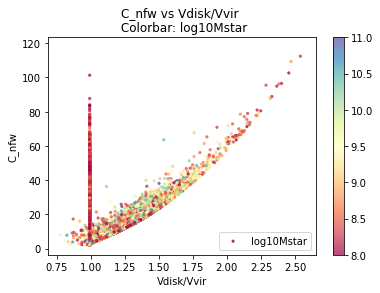

In [34]:
plt.scatter(df_normalized_31.loc[:, 'GalpropNormVdisk'], df_normalized_31.loc[:, 'HalopropC_nfw'],
            c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
#             c = df_normalized_31.loc[:,'GalpropNormMstar'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='log10Mstar', vmin=8.0, vmax=11.0)
plt.xlabel('Vdisk/Vvir')
plt.ylabel('C_nfw')
plt.title('C_nfw vs Vdisk/Vvir \n Colorbar: log10Mstar')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('C_nfw_vs_NormVdisk.jpeg', dpi=500)
plt.show()

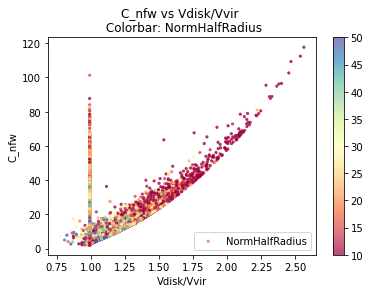

In [35]:
plt.scatter(df_normalized_31.loc[:, 'GalpropNormVdisk'], df_normalized_31.loc[:, 'HalopropC_nfw'],
#             c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            c = df_normalized_31.loc[:,'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormHalfRadius', vmin=10.0, vmax=50)
plt.xlabel('Vdisk/Vvir')
plt.ylabel('C_nfw')
plt.title('C_nfw vs Vdisk/Vvir \n Colorbar: NormHalfRadius')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('C_nfw_vs_NormVdisk_colorbar_NormHalfRadius.jpeg', dpi=500)
plt.show()

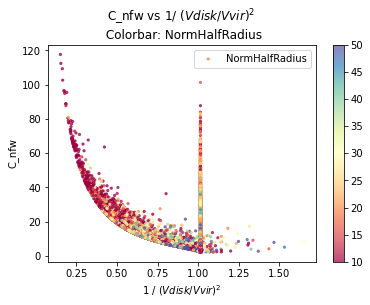

In [36]:
plt.scatter((1/(df_normalized_31.loc[:, 'GalpropNormVdisk'])**2), df_normalized_31.loc[:, 'HalopropC_nfw'],
#             c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            c = df_normalized_31.loc[:,'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormHalfRadius', vmin=10.0, vmax=50)
# plt.plot([0.0, 6], [0.0, 120], color = 'black', linewidth = 2)
plt.xlabel(r'1 / $(Vdisk/Vvir)^{2}$')
plt.ylabel('C_nfw')
plt.title(r'C_nfw vs 1/ $(Vdisk/Vvir)^{2}$' + ' \n Colorbar: NormHalfRadius')
plt.legend(loc='upper right')
plt.colorbar()
# plt.savefig('C_nfw_vs_inverseNormVdisksquared_colorbar_NormHalfRadius.jpeg', dpi=500)
plt.show()

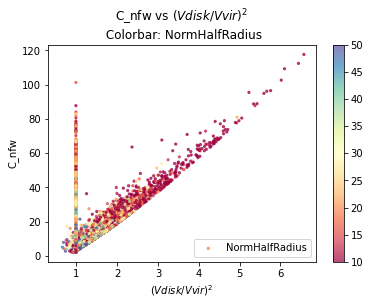

In [37]:
plt.scatter((df_normalized_31.loc[:, 'GalpropNormVdisk'])**2, df_normalized_31.loc[:, 'HalopropC_nfw'],
#             c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            c = df_normalized_31.loc[:,'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormHalfRadius', vmin=10.0, vmax=50)
# plt.plot([0.0, 6], [0.0, 120], color = 'black', linewidth = 2)
plt.xlabel(r'$(Vdisk/Vvir)^{2}$')
plt.ylabel('C_nfw')
plt.title(r'C_nfw vs $(Vdisk/Vvir)^{2}$' + ' \n Colorbar: NormHalfRadius')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('C_nfw_vs_NormVdisksquared_colorbar_NormHalfRadius.jpeg', dpi=500)
plt.show()

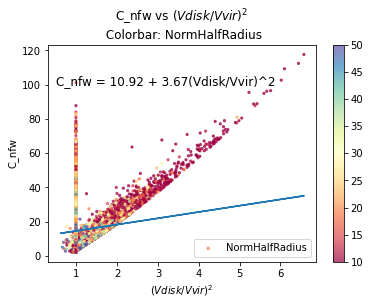

In [38]:
#find line of best fit
a1, b1 = np.polyfit((df_normalized_31.loc[:, 'GalpropNormVdisk'])**2, df_normalized_31.loc[:, 'HalopropC_nfw'], 1)


plt.scatter((df_normalized_31.loc[:, 'GalpropNormVdisk'])**2, df_normalized_31.loc[:, 'HalopropC_nfw'],
#             c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            c = df_normalized_31.loc[:,'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormHalfRadius', vmin=10.0, vmax=50)
# plt.plot([0.0, 6], [0.0, 120], color = 'black', linewidth = 2)
plt.xlabel(r'$(Vdisk/Vvir)^{2}$')
plt.ylabel('C_nfw')
plt.title(r'C_nfw vs $(Vdisk/Vvir)^{2}$' + ' \n Colorbar: NormHalfRadius')
plt.legend(loc='lower right')
plt.colorbar()

#add line of best fit to plot
# plt.plot(df_normalized_31.loc[:, 'HalopropC_nfw'], a1*((df_normalized_31.loc[:, 'GalpropNormVdisk'])**2)+b1) 
plt.plot((df_normalized_31.loc[:, 'GalpropNormVdisk'])**2, a1*((df_normalized_31.loc[:, 'GalpropNormVdisk'])**2)+b1 )
#add fitted regression equation to plot
plt.text(0.5, 100, 'C_nfw = ' + '{:.2f}'.format(b1) + ' + {:.2f}'.format(a1) + '(Vdisk/Vvir)^2', size=12)


# plt.savefig('C_nfw_vs_NormVdisksquared_colorbar_NormHalfRadius.jpeg', dpi=500)
plt.show()

In [39]:
# df excluding all normvdisk <=1.0
df_normalized_wovdisk1 = df_normalized_31.loc[df_normalized_31.GalpropNormVdisk > 1.0]

In [40]:
df_normalized_31.GalpropNormVdisk > 1.0

0        False
1         True
2        False
3        False
4        False
         ...  
35385    False
35386    False
35387     True
35388     True
35389    False
Name: GalpropNormVdisk, Length: 35390, dtype: bool

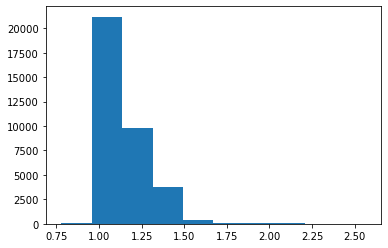

In [41]:
plt.hist(df_normalized_31['GalpropNormVdisk'])
plt.show()

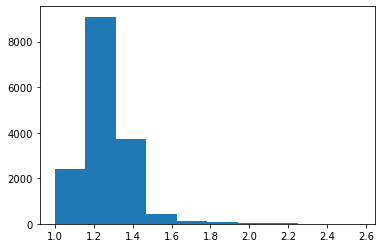

In [42]:
plt.hist(df_normalized_wovdisk1['GalpropNormVdisk'])
plt.show()

In [43]:
# 15,933 (out of 35,390; that is 45%) galaxies have normvdisk>1.0
df_normalized_wovdisk1.shape

(15933, 35)

In [44]:
df_normalized_31.shape

(35390, 35)

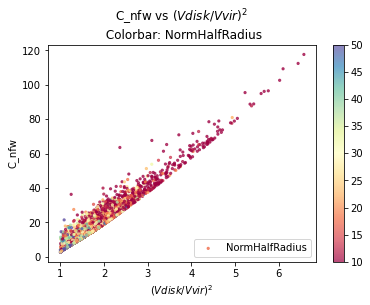

In [45]:
plt.scatter((df_normalized_wovdisk1['GalpropNormVdisk'])**2, df_normalized_wovdisk1.loc[:, 'HalopropC_nfw'],
#             c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            c = df_normalized_wovdisk1.loc[:,'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormHalfRadius', vmin=10.0, vmax=50)
# plt.plot([0.0, 6], [0.0, 120], color = 'black', linewidth = 2)
plt.xlabel(r'$(Vdisk/Vvir)^{2}$')
plt.ylabel('C_nfw')
plt.title(r'C_nfw vs $(Vdisk/Vvir)^{2}$' + ' \n Colorbar: NormHalfRadius')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('C_nfw_vs_NormVdisksquared_colorbar_NormHalfRadius.jpeg', dpi=500)
plt.show()

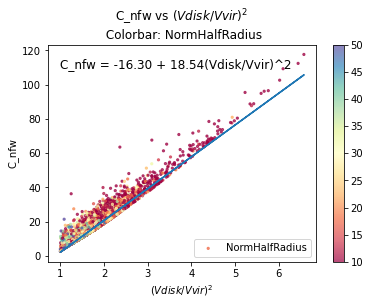

In [46]:
#find line of best fit
a1, b1 = np.polyfit((df_normalized_wovdisk1.loc[:, 'GalpropNormVdisk'])**2, df_normalized_wovdisk1.loc[:, 'HalopropC_nfw'], 1)


plt.scatter((df_normalized_wovdisk1.loc[:, 'GalpropNormVdisk'])**2, df_normalized_wovdisk1.loc[:, 'HalopropC_nfw'],
#             c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            c = df_normalized_wovdisk1.loc[:,'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormHalfRadius', vmin=10.0, vmax=50)
# plt.plot([0.0, 6], [0.0, 120], color = 'black', linewidth = 2)
plt.xlabel(r'$(Vdisk/Vvir)^{2}$')
plt.ylabel('C_nfw')
plt.title(r'C_nfw vs $(Vdisk/Vvir)^{2}$' + ' \n Colorbar: NormHalfRadius')
plt.legend(loc='lower right')
plt.colorbar()

#add line of best fit to plot
# plt.plot(df_normalized_31.loc[:, 'HalopropC_nfw'], a1*((df_normalized_31.loc[:, 'GalpropNormVdisk'])**2)+b1) 
plt.plot((df_normalized_wovdisk1.loc[:, 'GalpropNormVdisk'])**2, a1*((df_normalized_wovdisk1.loc[:, 'GalpropNormVdisk'])**2)+b1 )
#add fitted regression equation to plot
plt.text(1.0, 110, 'C_nfw = ' + '{:.2f}'.format(b1) + ' + {:.2f}'.format(a1) + '(Vdisk/Vvir)^2', size=12)


# plt.savefig('C_nfw_vs_NormVdisksquared_colorbar_NormHalfRadius_wovdisk1.jpeg', dpi=500)
plt.show()

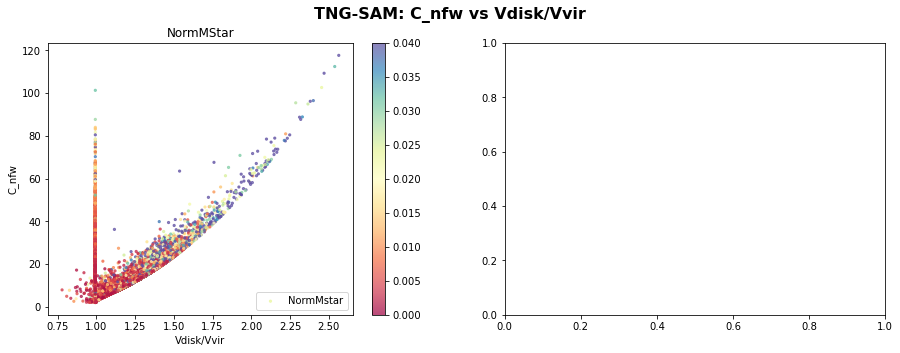

In [47]:
fig_cnfw, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig_cnfw.suptitle('TNG-SAM: C_nfw vs Vdisk/Vvir ', fontsize=16, fontweight='bold')

fig1 = ax1.scatter(df_normalized_31.loc[:, 'GalpropNormVdisk'], df_normalized_31.loc[:, 'HalopropC_nfw'],
            c = df_normalized_31.loc[:,'GalpropNormMstar'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormMstar', vmin=0.0, vmax=0.04)
ax1.set_xlabel('Vdisk/Vvir')
ax1.set_ylabel('C_nfw')
ax1.set_title('NormMStar')
ax1.legend(loc='lower right')
fig_cnfw.colorbar(fig1, ax=ax1)
plt.show()

fig2 = ax2.scatter(df_not_normalized.loc[:, 'GalpropVdisk']/df_not_normalized.loc[:, 'HalopropVvir'],
                   df_not_normalized.loc[:, 'HalopropC_nfw'],
            c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='log10Mstar', vmin=8.0, vmax=11.0)
ax2.set_xlabel('Vdisk/Vvir')
ax2.set_ylabel('C_nfw')
ax2.set_title('log10Mstar')
ax2.legend(loc='lower right')
fig_cnfw.colorbar(fig2, ax=ax2)

fig_cnfw.tight_layout()

plt.show()

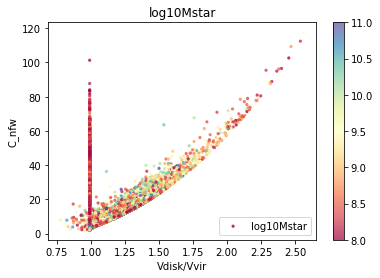

In [48]:
plt.scatter(df_not_normalized.loc[:, 'GalpropVdisk']/df_not_normalized.loc[:, 'HalopropVvir'],
                   df_not_normalized.loc[:, 'HalopropC_nfw'],
            c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='log10Mstar', vmin=8.0, vmax=11.0)
plt.xlabel('Vdisk/Vvir')
plt.ylabel('C_nfw')
plt.title('log10Mstar')
plt.legend(loc='lower right')
plt.colorbar()
plt.show()

In [49]:
def f_c(c):
    return 2.0 / 3.0 + (c / 21.5)**0.7

In [50]:
df_normalized_31.loc[:, 'f_c(c)'] = df_normalized_31.apply(lambda x: f_c(c=x['HalopropC_nfw']), axis=1)

In [51]:
df_normalized_31.shape

(35390, 36)

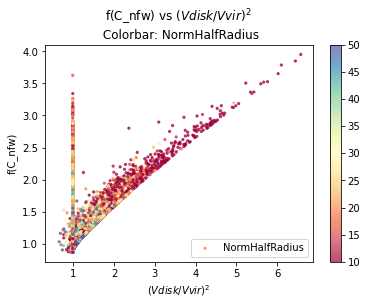

In [52]:
plt.scatter((df_normalized_31.loc[:, 'GalpropNormVdisk'])**2, df_normalized_31.loc[:, 'f_c(c)'],
#             c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            c = df_normalized_31.loc[:,'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormHalfRadius', vmin=10.0, vmax=50)
# plt.plot([0.0, 6], [0.0, 120], color = 'black', linewidth = 2)
plt.xlabel(r'$(Vdisk/Vvir)^{2}$')
plt.ylabel('f(C_nfw)')
plt.title(r'f(C_nfw) vs $(Vdisk/Vvir)^{2}$' + ' \n Colorbar: NormHalfRadius')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('C_nfw_vs_NormVdisksquared_colorbar_NormHalfRadius.jpeg', dpi=500)
plt.show()

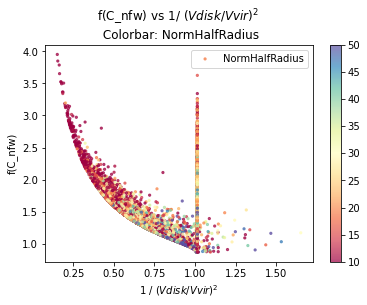

In [53]:
plt.scatter((1/(df_normalized_31.loc[:, 'GalpropNormVdisk'])**2), df_normalized_31.loc[:, 'f_c(c)'],
#             c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            c = df_normalized_31.loc[:,'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormHalfRadius', vmin=10.0, vmax=50)
# plt.plot([0.0, 6], [0.0, 120], color = 'black', linewidth = 2)
plt.xlabel(r'1 / $(Vdisk/Vvir)^{2}$')
plt.ylabel('f(C_nfw)')
plt.title(r'f(C_nfw) vs 1/ $(Vdisk/Vvir)^{2}$' + ' \n Colorbar: NormHalfRadius')
plt.legend(loc='upper right')
plt.colorbar()
# plt.savefig('funcC_nfw_vs_inverseNormVdisksquared_colorbar_NormHalfRadius.jpeg', dpi=500)
plt.show()

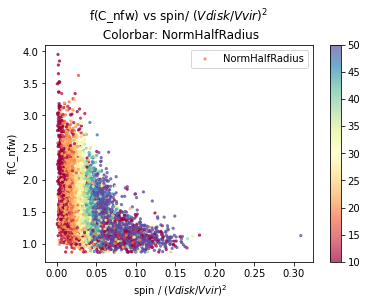

In [54]:
plt.scatter((df_normalized_31.loc[:,'HalopropSpin']/(df_normalized_31.loc[:, 'GalpropNormVdisk'])**2), df_normalized_31.loc[:, 'f_c(c)'],
#             c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            c = df_normalized_31.loc[:,'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormHalfRadius', vmin=10.0, vmax=50)
# plt.plot([0.0, 6], [0.0, 120], color = 'black', linewidth = 2)
plt.xlabel(r' spin / $(Vdisk/Vvir)^{2}$')
plt.ylabel('f(C_nfw)')
plt.title(r'f(C_nfw) vs spin/ $(Vdisk/Vvir)^{2}$' + ' \n Colorbar: NormHalfRadius')
plt.legend(loc='upper right')
plt.colorbar()
# plt.savefig('funcC_nfw_vs_spinNormVdisksquared_colorbar_NormHalfRadius.jpeg', dpi=500)
plt.show()